# Posture Detector Analysis

EDA and supervised classifier modelling of posture.

People in exaggerated and non-exaggerated postures where recorded
with 7 variables, angle and gravity for each orthogonal axis and
a flex sensor that bends with the body changing its resistance.

This notebook contains feature understanding, model selecting,
model hyperparametrization, and  model validation.

## Setup

In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import itertools
from sklearn import model_selection
import optuna

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, \
    QuadraticDiscriminantAnalysis
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import posture_detector
from posture_detector.constants import columns

In [247]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Load and parse dataset

In [14]:
data_location = 'data/raw/datalog_at_2021-06-20_19_25_06.648366'

In [15]:
df_raw = pd.read_csv('../' + data_location)
df_raw.head()

,Ax,Ay,Az,Temperature,gx,gy,gz,FlexSensor,Label
0,0.174805,-0.982422,-0.483887,28.8124,0.732824,-7.74046,-2.00763,552,NaN
1,0.213135,-0.960205,-0.447021,28.9065,-3.648850,5.93893,3.19084,552,NaN
2,0.178467,-0.978516,-0.437988,28.8124,-4.633590,1.19847,3.99237,552,NaN
3,0.187988,-0.970947,-0.478271,28.8124,-5.770990,-1.74046,2.25191,552,t
4,0.183838,-0.965820,-0.486572,28.9065,-3.129770,0.48855,1.58015,549,t


# Prepared Dataset

In [16]:
df = posture_detector.data.parse_dataset(df_raw)
df.head()


,Ax,Ay,Az,gx,gy,gz,FlexSensor,Label
116,0.038086,-0.985107,-0.409912,-2.55725,0.816794,2.81679,553,1
117,0.043457,-0.985596,-0.402832,-3.50382,0.824427,1.06870,553,1
118,0.049316,-0.985107,-0.424561,-3.85496,0.541985,1.00000,553,1
119,0.053467,-0.984375,-0.415039,-3.57252,0.534351,1.24427,554,1
120,0.056397,-0.978760,-0.426514,-3.35115,0.251908,1.18321,553,1


In [ ]:
X, y = posture_detector.data.train_test.split_record_data(df)

# EDA
Discover and understand the features

## How Variables differ over the labels?

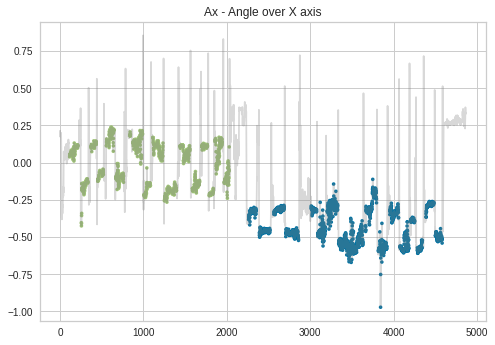

In [74]:
plt.title('Ax - Angle over X axis')
posture_detector.viz.plot_positions_from_df(
    df_raw, ['e', 'c'], columns.Record.Ax
)

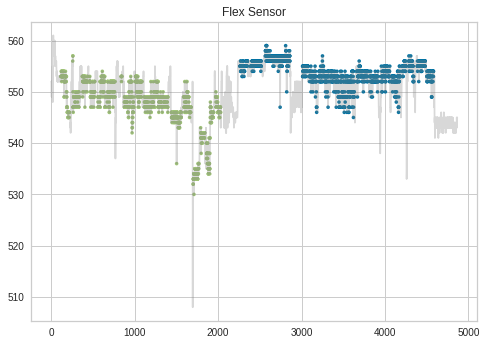

In [75]:
plt.title('Flex Sensor')
posture_detector.viz.plot_positions_from_df(
    df_raw, ['e', 'c'], columns.Record.Flex
)

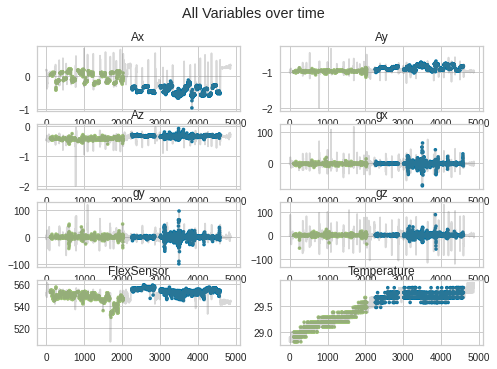

In [89]:
figure, axis = plt.subplots(4, 2)
cols = [
    columns.Record.Ax,
    columns.Record.Ay,
    columns.Record.Az,
    columns.Record.Gx,
    columns.Record.Gy,
    columns.Record.Gz,
    columns.Record.Flex,
    columns.Record.T,
]

for ax, col in zip(axis.flat, cols):
    posture_detector.viz.plot_positions_from_df(
        df_raw, ['e', 'c'], col, ax
    )
    ax.set_title(col)
plt.suptitle('All Variables over time')
plt.show()

It looks like the Ay variable is not varying between
the classes, at least not as much as Ax and FlexSensor

The temperature increase over time makes no sense so
it should be dropped.

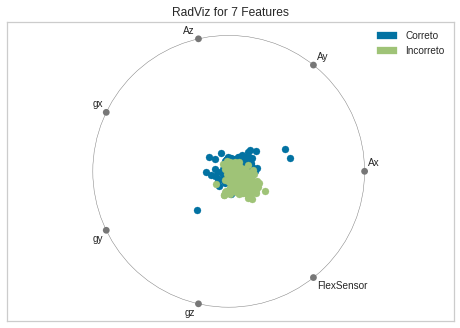

In [93]:
posture_detector.viz.plot_radial_feature_comparisons(X, y )

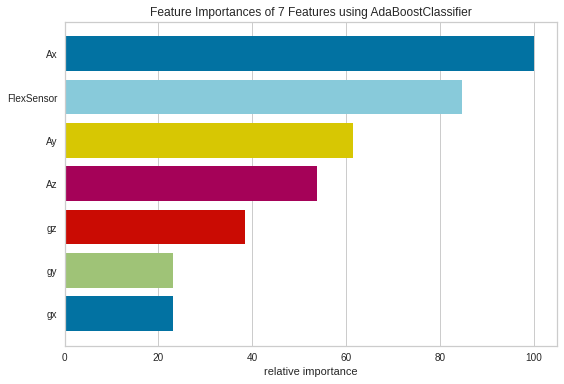

In [92]:
posture_detector.viz.plot_feature_importances(X, y)

# Selecting Models

## List Candidates

In [77]:
lda_model = LinearDiscriminantAnalysis(
    solver='lsqr'
)

In [78]:
qda = QuadraticDiscriminantAnalysis()

In [121]:
ridge_model = RidgeClassifier()

In [80]:
kn_model = KNeighborsClassifier()

In [81]:
# gpc_model = GaussianProcessClassifier()

In [82]:
ada_model = AdaBoostClassifier()

In [83]:
forest_clf = RandomForestClassifier()

In [84]:
dtree_clf = DecisionTreeClassifier()

## Evaluating Models

In [122]:
model_register = [
    ('lda', lda_model),
    ('ridge', ridge_model),
    ('qda', qda),
    ('kn', kn_model),
    ('forest_clf', forest_clf),
    ('ada_model', ada_model),
    ('dtree', dtree_clf)
    # ('gpc_model', gpc_model),
]

In [265]:
df_compare = posture_detector.models.tasks.get_model_comparisons_dataframe(
    model_register,
    X, y,
    scoring=('accuracy', 'recall', 'f1', 'precision'),
    cv=5,
)
df_compare

accuracy          recall              f1         precision        
              train    test   train    test   train    test     train    test
lda          0.9896  0.9881  0.9883  0.9885  0.9827  0.9825    0.9804  0.9790
ridge        0.9896  0.9837  0.9882  0.9928  0.9833  0.9762    0.9807  0.9864
qda          0.9855  0.9941  0.9838  0.9738  0.9765  0.9846    0.9743  0.9659
kn           0.9361  0.9276  0.9277  0.9280  0.8741  0.8496    0.8543  0.8789
forest_clf   1.0000  1.0000  1.0000  1.0000  0.9703  0.9678    0.9667  0.9699
ada_model    0.9999  1.0000  0.9999  0.9998  0.9660  0.9587    0.9611  0.9692
dtree        1.0000  1.0000  1.0000  1.0000  0.9623  0.9531    0.9568  0.9668

The comparisons show that lda and ridge have the best results because
they perform better in test metrics (even if forest and decision tree
perform better at training which indicates overfit.

Also, lda and ridge have very close train test values indicating good
bias variance tradeoff.

That's surprising since they're the simplest model which make
them ever better.

# Model Hyperparametrization

# Ridge Model

In [254]:
def objective(trial: optuna.trial.Trial):
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e+6),
    solver = trial.suggest_categorical('solver', ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])

    ridge_clf = RidgeClassifier(
        alpha = alpha,
        solver = solver,
    )
    result = model_selection.cross_validate(
        ridge_clf,
        X, y,
        cv=5,
        scoring='recall'
    )
    return np.mean(result['test_score'])

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500, n_jobs=12, show_progress_bar=True)

/home/gabriel/dev/posture_detector/venv/lib/python3.9/site-packages/optuna/_optimize.py:79: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")


In [255]:
print(f'study.best_params: {study.best_params}')
print(f'study.best_value: {study.best_value}')

study.best_params: {'alpha': 0.0003203396766828087, 'solver': 'svd'}
study.best_value: 0.9825174825174825


In [258]:
hyper_ridge_clf = RidgeClassifier(
        alpha=study.best_params['alpha'],
        solver=study.best_params['solver'],
    )
res = posture_detector.models.tasks.get_model_comparisons_dataframe(
    [('hyper_ridge_clf', hyper_ridge_clf)],
    X, y,
    scoring=('recall', 'accuracy', 'f1', 'precision')
)
res.T

hyper_ridge_clf
recall    train           0.9881
          test            0.9896
accuracy  train           0.9883
          test            0.9885
f1        train           0.9825
          test            0.9827
precision train           0.9804
          test            0.9790

# LDA Model

In [296]:
def objective(trial: optuna.trial.Trial):
    n_components = trial.suggest_int('n_components', 1, 7)
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])
    # shrinkage = trial.suggest_categorical('shrinkage', [None, 1, .25, .5, .75, .1])
    lda_clf = LinearDiscriminantAnalysis(
        n_components=n_components,
        solver=solver,
        # shrinkage=shrinkage,
    )
    result = model_selection.cross_validate(
        lda_clf,
        X, y,
        cv=5,
        n_jobs=5,
        scoring='f1'
    )
    return np.mean(result['test_score'])

study = optuna.create_study()
study.optimize(objective, n_trials=200)


In [297]:
print(f'study.best_params: {study.best_params}')
print(f'study.best_value: {study.best_value}')

study.best_params: {'n_components': 1, 'solver': 'svd'}
study.best_value: 0.98042276720095


In [298]:
hyper_lda_clf = LinearDiscriminantAnalysis(
        n_components=study.best_params['n_components'],
        solver=study.best_params['solver'],
        # shrinkage=study.best_params['shrinkage'],
    )
res = posture_detector.models.tasks.get_model_comparisons_dataframe(
    [('hyper_lda_clf', hyper_lda_clf)],
    X, y,
    scoring=('recall', 'accuracy', 'f1', 'precision')
)
res.T

hyper_lda_clf
recall    train         0.9881
          test          0.9896
accuracy  train         0.9883
          test          0.9885
f1        train         0.9825
          test          0.9827
precision train         0.9804
          test          0.9790

## Comparing Both

In [301]:
model_register = [
    ('hyper_ridge_clf', hyper_ridge_clf),
    ('hyper_lda_clf', hyper_lda_clf),
]
posture_detector.models.tasks.get_model_comparisons_dataframe(
    model_register,
    X, y,
    scoring=('recall', 'accuracy', 'f1', 'precision'),
    decimals=10
)

recall           accuracy                  f1            \
                    train      test    train      test     train      test   
hyper_ridge_clf  0.988104  0.989638  0.98828  0.988482  0.982517  0.982678   
hyper_lda_clf    0.988104  0.989638  0.98828  0.988482  0.982517  0.982678   

                precision            
                    train      test  
hyper_ridge_clf  0.980423  0.979049  
hyper_lda_clf    0.980423  0.979049